In [ ]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

In [1]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learner import Learner

sb.set_style('whitegrid')

In [2]:
# Set up the system
system = RevDuffing()

In [3]:
# Instantiate the observer
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised')
observer.set_dynamics(system)
# Generate (x_i, z_i) data by running system backward, then system + observer
# forward in time
data = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), 10000)
print(data.shape)
data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

# Train the forward transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data,
                    validation_data=val_data, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


torch.Size([10000, 5])
Results saved in in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T/exp_2


In [4]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T)
learner_T.save_results(limits=np.array([[-1, 1.], [-1., 1.], [-1., 1.]]),
                       nb_trajs=10, tsim=(0, 60), dt=1e-2,
                       checkpoint_path=checkpoint_callback.best_model_path)


  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Logs stored in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T/exp_2/tb_logs


Validation sanity check: 0it [00:00, ?it/s]

/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in t

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved model in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T/exp_2


0

In [5]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 20}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
# learner_T_star = Learner(T??, data, True, "T_star")???  # TODO
learner_T_star = Learner(observer=observer, system=system, training_data=data,
                         validation_data=val_data, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Results saved in in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T_star/exp_0


In [6]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T_star.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T_star)
learner_T_star.save_results(limits=np.array([[-1, 1.], [-1., 1.]]),
                            nb_trajs=10, tsim=(0, 60), dt=1e-2,
                            checkpoint_path=checkpoint_callback.best_model_path)


  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Logs stored in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T_star/exp_0/tb_logs


Validation sanity check: 0it [00:00, ?it/s]

/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in t

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    12: reducing learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch    16: reducing learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Saved model in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T_star/exp_0


No handles with labels found to put in legend.


Shape of mesh for evaluation: torch.Size([10000, 5])


No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [7]:
# Simulate one test trajectory
import torch
tsim = (0, 60)
dt = 1e-2
tq, simulation = system.simulate(torch.tensor([[0.5, 0.5]]), tsim, dt)
print(tq.shape, simulation.shape)
# measurement = observer.h(simulation[:, :, 0].T).T
measurement = observer.h(simulation)
print(measurement.shape)
y = torch.cat((tq.unsqueeze(1), measurement), dim=1)

# Predict from measurment
estimation = observer.predict(y, tsim, dt)

torch.Size([6000]) torch.Size([6000, 2])
torch.Size([6000, 1])


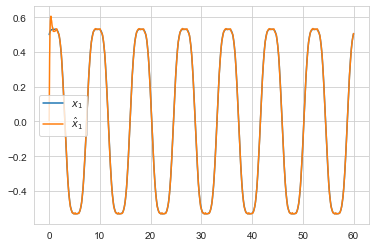

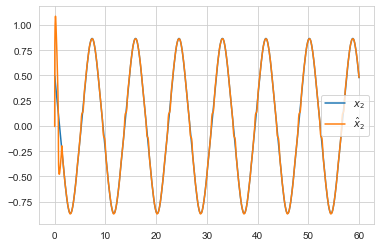

In [8]:
# Plot ground truth and state estimation<

import matplotlib.pyplot as plt
for i in range(simulation.shape[1]):
        plt.plot(tq, simulation[:, i], label=rf'$x_{i+1}$')
        plt.plot(tq, estimation[:, i].detach().numpy(),
                 label=rf'$\hat{{x}}_{i+1}$')
        plt.legend()
        plt.show()

No handles with labels found to put in legend.


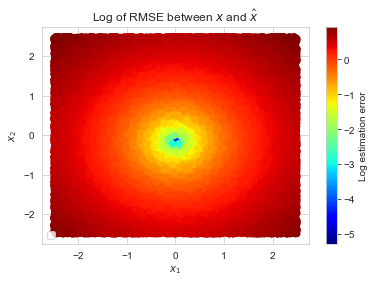

In [9]:
# Extra tests
import os
from smt.sampling_methods import LHS
from learn_KKL.utils import RMSE, StandardScaler
num_samples = 50000
sampling = LHS(xlimits=np.array([[-2.5, 2.5], [-2.5, 2.5]]))
mesh = torch.as_tensor(sampling(num_samples))
_, mesh_hat = learner_T_star.model('Autoencoder', mesh)
error = RMSE(mesh, mesh_hat, dim=1)
for i in range(1, mesh.shape[1]):
    name = 'Invertibility_heatmap' + str(i) + '.pdf'
    plt.scatter(mesh[:, i - 1], mesh[:, i], cmap='jet',
                c=np.log(error.detach().numpy()))
    cbar = plt.colorbar()
    cbar.set_label('Log estimation error')
    plt.title('Log of RMSE between ' + r'$x$' + ' and '
              + r'$\hat{'r'x}$')
    plt.xlabel(rf'$x_{i}$')
    plt.ylabel(rf'$x_{i + 1}$')
    plt.legend()
    plt.show()

torch.Size([10000, 5]) (0, 60) 0.01 torch.Size([10000, 2])


No handles with labels found to put in legend.


torch.Size([1000, 10000, 5]) torch.Size([10000, 5])
torch.Size([10000, 2]) torch.Size([10000])


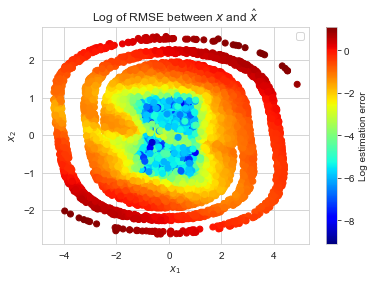

In [10]:
# Heatmap of RMSE(x, x_hat) with T_star
num_samples = 10000
# heatmap_data = learner.model.generate_data_svl(np.array([[-2.5, 2.5], [-2.5, 2.5]]), num_samples)
# x = heatmap_data[:, :learner.model.dim_x]
# z = heatmap_data[:, learner.model.dim_x:]
sampling = LHS(xlimits=np.array([[-2.5, 2.5], [-2.5, 2.5]]))
init_x = torch.as_tensor(sampling(num_samples))
init = torch.zeros((num_samples, learner_T_star.model.dim_x + learner_T_star
                    .model.dim_z))
init[:, :learner_T_star.model.dim_x] = init_x
print(init.shape, tsim, dt, init_x.shape)
tsim = (0, 10)
dt = 1e-2
tq, data_fw = learner_T_star.model.simulate_system(init, tsim, dt)
# heatmap_data = torch.transpose(data_fw[-1, :, :], 0, 1)
heatmap_data = data_fw[-1]
print(data_fw.shape, heatmap_data.shape)
x = heatmap_data[:, :learner_T_star.model.dim_x]
z = heatmap_data[:, learner_T_star.model.dim_x:]
x_hat = learner_T_star.model('T_star', z)
error = RMSE(x, x_hat, dim=1)
print(x.shape, error.shape)
for i in range(1, x.shape[1]):
    # https://stackoverflow.com/questions/37822925/how-to-smooth-by-interpolation-when-using-pcolormesh
    name = 'RMSE_heatmap' + str(i) + '.pdf'
    plt.scatter(x[:, i - 1], x[:, i], cmap='jet',
                c=np.log(error.detach().numpy()))
    cbar = plt.colorbar()
    cbar.set_label('Log estimation error')
    # print(x[:, i - 1:i + 1].shape)
    # plt.imshow(x[:, i - 1:i + 1], cmap='jet',
    #            c=np.log(error.numpy()))
    # plt.pcolormesh(x[:, i - 1], x[:, i], np.log(error),
    #                cmap='jet', shading='gouraud')
    # cbar = plt.colorbar()
    # cbar.set_label('Log estimation error')
    # cbar = plt.colorbar()
    cbar.set_label('Log estimation error')
    plt.title('Log of RMSE between ' + r'$x$' + ' and '
              + r'$\hat{'r'x}$')
    plt.xlabel(rf'$x_{i}$')
    plt.ylabel(rf'$x_{i + 1}$')
    plt.legend()
    plt.show()


No handles with labels found to put in legend.


torch.Size([10000, 2]) torch.Size([10000]) torch.Size([10000, 3])


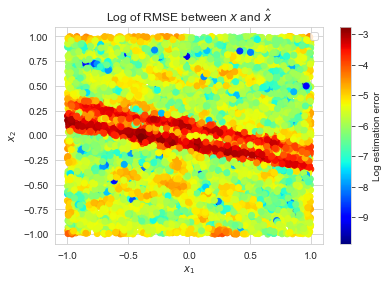

In [11]:
# Heatmap of RMSE(x, x_hat) with T_star
num_samples = 10000
heatmap_data = learner_T_star.model.generate_data_svl(np.array([[-1.,1],
                                                                [-1.,1]]),
                                                      num_samples)
x = heatmap_data[:, :learner_T_star.model.dim_x]
z = heatmap_data[:, learner_T_star.model.dim_x:]
x_hat = learner_T_star.model('T_star', z)
error = RMSE(x, x_hat, dim=1)
print(x.shape, error.shape, z.shape)
for i in range(1, x.shape[1]):
    # https://stackoverflow.com/questions/37822925/how-to-smooth-by-interpolation-when-using-pcolormesh
    name = 'RMSE_heatmap' + str(i) + '.pdf'
    plt.scatter(x[:, i - 1], x[:, i], cmap='jet',
                c=np.log(error.detach().numpy()))
    cbar = plt.colorbar()
    cbar.set_label('Log estimation error')
    # print(x[:, i - 1:i + 1].shape)
    # plt.imshow(x[:, i - 1:i + 1], cmap='jet',
    #            c=np.log(error.numpy()))
    # plt.pcolormesh(x[:, i - 1], x[:, i], np.log(error),
    #                cmap='jet', shading='gouraud')
    # cbar = plt.colorbar()
    # cbar.set_label('Log estimation error')
    # cbar = plt.colorbar()
    cbar.set_label('Log estimation error')
    plt.title('Log of RMSE between ' + r'$x$' + ' and '
              + r'$\hat{'r'x}$')
    plt.xlabel(rf'$x_{i}$')
    plt.ylabel(rf'$x_{i + 1}$')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


Shape of mesh for evaluation: torch.Size([10000, 5])
torch.Size([10000])
torch.Size([10000, 2]) torch.Size([10000, 3])


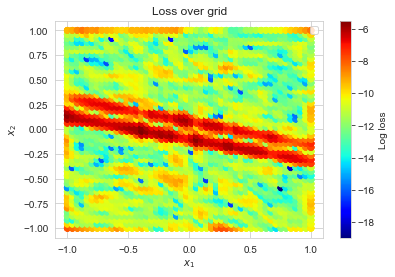

In [20]:
nb_trajs = 10
verbose = True
num_samples = 100
limits = np.array([[-1.,1], [-1.,1]])
tsim=(0, 60)
dt=1e-2
mesh = learner_T_star.model.generate_data_svl(limits, num_samples, method='uniform')
print(f'Shape of mesh for evaluation: {mesh.shape}')
x_mesh = mesh[:, :learner_T_star.model.dim_x]
z_mesh = mesh[:, learner_T_star.model.dim_x:]
x_hat_star = learner_T_star.model('T_star', z_mesh)
z_hat_T, x_hat_AE = learner_T_star.model('Autoencoder', x_mesh)
# Loss heatmap
losses = []
if learner_T_star.method == "Autoencoder":
    # z_hat, x_hat = learner_T_star.model(learner_T_star.method, x_mesh)
    loss, loss1, loss2 = learner_T_star.model.loss_autoencoder(
        x_mesh, x_hat_AE, z_hat_T, dim=-1)
    losses.append(loss1)
    losses.append(loss2)
elif learner_T_star.method == "T_star":
    # x_hat = learner_T_star.model(learner_T_star.method, z_mesh)
    loss = learner_T_star.model.loss_T_star(x_mesh, x_hat_star, dim=-1)
    losses.append(loss)
for loss in losses:
    print(loss.shape)
print(x_mesh.shape, z_mesh.shape)
for j in range(len(losses)):
    loss = losses[j]
    for i in range(1, x_mesh.shape[1]):
        name = f'Loss{j}_{i}.pdf'
        plt.scatter(x_mesh[:, i - 1], x_mesh[:, i], cmap='jet',
                    c=np.log(loss.detach().numpy()))
        cbar = plt.colorbar()
        cbar.set_label('Log loss')
        plt.title('Loss over grid')
        plt.xlabel(rf'$x_{i}$')
        plt.ylabel(rf'$x_{i + 1}$')
        plt.legend()
        plt.savefig(os.path.join(learner_T_star.results_folder, name),
                    bbox_inches='tight')
        plt.show()
        plt.close('all')